# DFT MD on disordered `HfNbTaZr` alloy

A disordered equiatomic `HfNbTaZr` crystal was generated in Vesta using atomic positions seeded randomly using `mcsqs`.

This notebook handles a few things:
1. Slab relaxation, if `RUN_RELAXATION=True`
2. MD run at configurable # time steps, dt, initial eV
3. Previewing system (`preview(...)`)

Use `ase gui <output_filename.out>` to view animated relax/MD output.

# Helpers

In [22]:
from ase import Atom, Atoms
from ase.calculators.espresso import Espresso
from ase.constraints import FixAtoms
from ase.io.cif import read_cif
from ase.io.espresso import read_espresso_out, write_espresso_in
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms

from copy import deepcopy
from matplotlib import pyplot as plt
import math
import numpy as np
from datetime import datetime

from qe_utils import (#velocity,
    import_vasp,
    output_to_atoms,
    relax,
    pin_bottom_layers,
    #get_D_position,
    preview,
    md,
    sanitize)

In [18]:
# Numeric constants
# 1 picosecond = n Rydberg a.u.
PS_TO_AU = 1e-12 / (4.8378 * 1e-17)

# 1 femtosecond
FS_TO_AU = 1e-15 / (4.8378 * 1e-17)

In [19]:
#########################################################################
# RUN_RELAXATION
#    - True: run a relaxation step (can take several hours)
#    - False: don't run a relaxation step, use an existing relaxed crystal
# An existing relaxed crystal exists in relax_data/relax_Hf5Nb2Ta10Zr5.out
#########################################################################
RUN_RELAXATION = False

#########################################################################
# VACUUM
#    - Amount of vacuum, in Angstroms, to place on either side of the system
#########################################################################
VACUUM = 2.0

#########################################################################
# DEUTERIUM_MASS_AMU
#    - Deuterium mass in AMU
#########################################################################
DEUTERIUM_MASS_AMU = 2.014

#########################################################################
# INITIAL_DISTANCE_A
#    - Initial distance between D atom and surface of slab, in Angstroms
#########################################################################
INITIAL_DISTANCE_A = 3.0

#########################################################################
# AXIS
#    - One of { 'x', 'y', 'z' }: axis along which the D atom should travel
#########################################################################
AXIS = 'x'

#########################################################################
# N_STEPS
#    - Number of steps to run MD for
#########################################################################
N_STEPS = 15

#########################################################################
# INITIAL_EV
#    - Initial eV to impart on D atom
#########################################################################
INITIAL_EV = 1000

#########################################################################
# DT
#    - dt, in AU
#########################################################################
DT = 0.2 * round(FS_TO_AU) # 0.2fs

INCIDENT_ANGLE_DEG = 45
POLAR_ANGLE_DEG = 45

In [13]:
atoms.positions[:-1]

array([[2.66999996, 2.82712303, 6.60396422],
       [1.25299068, 1.28628418, 5.05846623],
       [1.2554869 , 7.38980429, 5.08806777],
       [4.08700923, 1.28628418, 5.05846623],
       [4.08451302, 7.38980429, 5.08806777],
       [2.66999996, 2.79693061, 3.51558322],
       [2.66999996, 5.87637868, 6.63499794],
       [1.20937306, 4.34092785, 5.07112583],
       [4.13062686, 4.34092785, 5.07112583],
       [1.30725268, 1.31412259, 2.05877911],
       [1.30278831, 1.30839114, 8.0945792 ],
       [1.30400962, 7.37582612, 2.04623718],
       [1.3077108 , 7.36508295, 8.08600222],
       [4.03274723, 1.31412259, 2.05877911],
       [4.0372116 , 1.30839114, 8.0945792 ],
       [4.03599029, 7.37582612, 2.04623718],
       [4.03228912, 7.36508295, 8.08600222],
       [2.66999996, 5.86628584, 3.52738393],
       [1.24383462, 4.32207796, 2.        ],
       [1.24038541, 4.35412328, 8.14975555],
       [4.09616529, 4.32207796, 2.        ],
       [4.0996145 , 4.35412328, 8.14975555]])

In [41]:
def velocity(atomic_mass, energy, normal_angle_deg=0, polar_angle_deg=0):
    """
    Computes the velocity of an atom in Hartree atomic units, given the atomic mass in atomic units and the energy in electronvolts.

    Args:
    atomic_mass: The atomic mass of the atom in atomic units.
    energy: The energy of the atom in electronvolts.

    Returns:
    The velocity of the atom in Hartree atomic units.
    """

    # Convert the atomic mass to kilograms.
    atomic_mass_kg = atomic_mass * 1.660539040e-27

    # Convert the energy to joules.
    energy_joules = energy * 1.60217662e-19

    # Calculate the velocity.
    velocity_ms = math.sqrt((2 * energy_joules) / atomic_mass_kg)

    # Convert the velocity to Hartree atomic units.
    velocity_ha = velocity_ms / 2.187691e6
    
    normal_angle_rad, polar_angle_rad = np.radians(normal_angle_deg), np.radians(polar_angle_deg)
    planar_magnitude = velocity_ha * np.sin(normal_angle_rad)
    vx = velocity_ha * np.cos(normal_angle_rad)
    vy = planar_magnitude * np.cos(polar_angle_rad)
    vz = planar_magnitude * np.sin(polar_angle_rad)
    
    return (vx, vy, vz)

assert velocity(1., 100, 0, 0) == velocity(1., 100, 0, 360)
assert np.all(np.isclose(
    velocity(1., 100, 45, 0),
    velocity(1., 100, 45, 360)
))

In [43]:
velocity(1., 100, 0, 0), velocity(1., 100, 45, 90)

((0.06349794457000221, 0.0, 0.0),
 (0.04489982719685608, 2.7493214829449536e-18, 0.044899827196856076))

In [10]:
def get_D_position(atoms, initial_distance_a=5.0, axis='z', normal_angle_deg=0, polar_angle_deg=0):
    """
    Get a position at which to place a single D atom.
    
    Args:
        atoms: ase.Atoms object
        initial_distance_a: initial distance between top of slab & D atom, in Angstroms
        normal_angle_deg: Angle from slab surface normal, in degrees
        polar_angle_deg: Angle on face of slab. y-axis (up) is 0deg
    """
    if axis != 'x':
        raise NotImplementedError

    normal_angle_rad, polar_angle_rad = np.radians(normal_angle_deg), np.radians(polar_angle_deg)
    radius = initial_distance_a * np.sin(normal_angle_rad)
    dx = initial_distance_a * np.cos(normal_angle_rad)
    dy = radius * np.cos(polar_angle_rad)
    dz = radius * np.sin(polar_angle_rad)
    
    mean_xyz = np.mean(atoms.positions, axis=0)
    top_x = np.max(atoms.positions[:, 0]) # largest cartesian x coordinate (top of slab)
    return np.array([top_x + dx, mean_xyz[1] + dy, mean_xyz[2] + dz])

## Add vacuum and a single `D` atom

Fix the crystal in place & add vacuum on either side. Then add an unconstrained `D` atom `INITIAL_DISTANCE_A` Angstroms away from the slab.

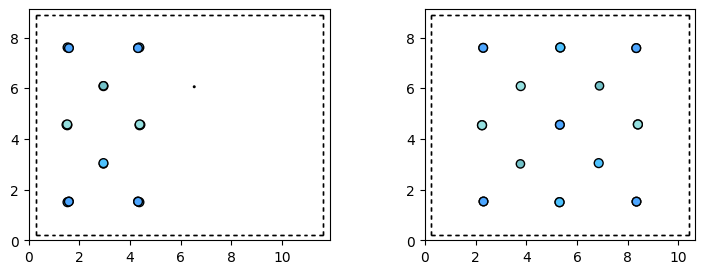

In [11]:
# Run relaxation, if needed
if RUN_RELAXATION:
    slab = import_vasp('input/HfNbTaZr_8.vasp', truncate=False)
    slab.center(vacuum=1)
    relax_output_filename = relax(slab)
    
# Create our slab
slab = output_to_atoms(relax_output_filename if RUN_RELAXATION else 'relax_data/relax_Hf5Nb2Ta10Zr5.out') # This slab is the result of relaxing a 22-atom crystal
atoms = deepcopy(slab)
atoms.center(vacuum=VACUUM, axis=2)
atoms = pin_bottom_layers(atoms, nlayers=1, axis=AXIS)

# Place the D atom in the center of the slab, `INITIAL_DISTANCE_A` Angstroms away
DEUTERIUM_XYZ = get_D_position(atoms, initial_distance_a=INITIAL_DISTANCE_A, axis=AXIS, normal_angle_deg=INCIDENT_ANGLE_DEG, polar_angle_deg=POLAR_ANGLE_DEG)
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=DEUTERIUM_XYZ)
atoms.append(deuterium)

# Expand unit cell so that the D atom fits
existing_cell = atoms.get_cell()
atoms.set_cell(np.array([ # TODO this code is dogshit, clean it up
    existing_cell[0][0] + (2 * INITIAL_DISTANCE_A if AXIS == 'x' else 0),
    existing_cell[1][1] + (2 * INITIAL_DISTANCE_A if AXIS == 'y' else 0),
    existing_cell[2][2] + (2 * INITIAL_DISTANCE_A if AXIS == 'z' else 0)]
))

preview(atoms)

## Run MD

In [17]:
output_filename = md(atoms, nsteps=N_STEPS, dt=DT, initial_eV=INITIAL_EV, incident_angle_deg=INCIDENT_ANGLE_DEG, polar_angle_deg=POLAR_ANGLE_DEG, ncores=12)

Writing D initial velocity 1000eV (0.14149136432947648 Hartree au)


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


AttributeError: 'int' object has no attribute 'wait'

In [19]:
# We have to do this bit to get `ase` to be able to read the file in again
# TODO: file bugfix PR in ase
sanitize(output_filename)

Preserving existing job output in md_Hf5Nb2Ta10Zr5H_15steps_1000eV_incident45_polar45.out.old


From here, run `ase gui <output_filename>` to view the animation